# OOI IFCB Raw Data Archive JupyterHub Example
In this example, we will sift through the CP10CNSM PLIMS (IFCB) recovered data and select an arbitrary IFCB sample to display images from.

An IFCB sample consists of 3 files (.hdr, .adc, .roi). The .hdr file provides engineering information and defines the structure of the .acd file. The .acd file provides metadata from the roi images that accompany each sample and allows for parsing of the .roi file. The .roi file contains a flat bytes stream that can be converted to images if you know the start byte and the size of the region of interest.

You can also think of an IFCB "sample" as the number of collections that occur in the time it takes for the IFCB to collect data on a single syringe.

In [1]:
from datetime import datetime
import pandas as pd
from PIL import Image
import xarray as xr
import yaml
import glob
import os

## Helper Functions

In [2]:
def find_plims_files(site: str, deployment_type: str = 'R') -> dict:
    """
    Find .hdr, .adc, and .roi files associated with a site deployment.

    :param site: An 8-character designator for the OOI site.
    :param deployment_type: An indicator of whether or not to look in recovered (R) or telemetered (D) datasets.
    :return: A dictionary where the key is the basename of the IFCB sample and the value is a dictionary containing filepaths to the matching files.
    """
    
    __user_dir = os.path.expanduser('~')
    uncabled_dir = os.path.join(__user_dir, 'ooi/uncabled/')
    site_dir = os.path.join(uncabled_dir, site)
    roi_files = glob.glob(os.path.join(site_dir, f'**/*{deployment_type.upper()}*/**/cg_data/**/*.roi'), recursive = True)
    adc_files = glob.glob(os.path.join(site_dir, f'**/*{deployment_type.upper()}*/**/cg_data/**/*.adc'), recursive = True)
    hdr_files = glob.glob(os.path.join(site_dir, f'**/*{deployment_type.upper()}*/**/cg_data/**/*.hdr'), recursive = True)
    
    files = {}
    for roi_file in roi_files:
        basename, _ = os.path.splitext(os.path.basename(roi_file))
        
        matching_adc = [f for f in adc_files if basename in f]
        if len(matching_adc) == 1:
            matching_adc = matching_adc[0]
        else:
            msg = f'No adc files or multiple files returned for {basename}.'
            raise ValueError
        matching_hdr = [f for f in hdr_files if basename in f]
        
        if len(matching_hdr) == 1:
            matching_hdr = matching_hdr[0]
        else:
            msg = f'No hdr files or multiple files returned for {basename}.'
            raise ValueError
            
        files[basename] = {'roi': roi_file,
                           'hdr': matching_hdr,
                           'adc': matching_adc}

    files = dict(sorted(files.items()))
    return files


def extract_sample_info(name:str) -> tuple:
    """
    Determine the sample time and serial number for the base filename.

    :param name: The base filename extracted from a filepath.
    :return: The datetime of the sample as a Pythonic datetime object and the serial number.
        In the form of a tuple (dt, sn).
    """
    dt_str, sn = name.split('_')
    dt = datetime.strptime(dt_str, 'D%Y%m%dT%H%M%S')
    return (dt, sn)


def load_roi(roi_filepath: str) -> bytes:
    """
    Load a .roi file. The .roi file contains data for multiple ROIs.

    :param roi_filepath: The absolute filepath of the .roi file.
    :return: The data in the .roi file, as bytes.
    """
    
    with open(roi_filepath, 'rb') as _file:
        rfb = _file.read()
    return rfb


def load_hdr(hdr_filepath: str) -> dict:
    """
    Load an IFCB .hdr file as a dictionary. 
    There is no guarantee that .hdr files will remain YAML files in the future

    :param hdr_filepath: The absolute filepath of the .hdr file.
    :return: Contents of the .hdr file as a dictionary.
    """
    
    with open(hdr_filepath,'r') as _file:
        hdr_data = yaml.safe_load(_file)
    return hdr_data


def load_adc(name: str, adc_filepath: str, hdr_filepath :str) -> xr.Dataset:
    """
    Load an IFCB .adc file as an xarray.Dataset.

    :param name: The basename of the roi file.
    :param adc_filepath: The absolute filepath of the .adc file.
    :param hdr_filepath: The absolute filepath of the .hdr file. The adc format is determined by
        the .hdr file. Other values arr assigned as attributes.
    :return: adc data as an xarray.Dataset.
    """

    dt, sn = extract_sample_info(name)
    
    hdr = load_hdr(hdr_filepath)

    adc_format = hdr['ADCFileFormat']    
    adc_format = adc_format.split(',')
    adc_format = [col.replace('#','') for col in adc_format] # Replace any hashes.
    adc_format = [col.replace(' ','') for col in adc_format] # Remove any spaces in column names.

    _df = pd.read_csv(adc_filepath, names = adc_format)

    adc = _df.to_xarray()

    adc = adc.rename({'trigger': 'trigger_number',
                      'ADCtime': 'adc_time',
                      'PMTA':'pmt_a',
                      'PMTB':'pmt_b',
                     'PMTC':'pmt_c',
                     'PMTD':'pmt_d',
                     'PeakA':'peak_a',
                     'PeakB': 'peak_b',
                     'PeakC': 'peak_c',
                     'PeakD': 'peak_d',
                     'TimeOfFlight':'time_of_flight',
                     'GrabTimeStart': 'grab_time_start',
                     'GrabTimeEnd': 'grab_time_end',
                     'RoiX': 'roi_x',
                     'RoiY': 'roi_y',
                     'RoiWidth': 'roi_width',
                     'RoiHeight': 'roi_height',
                     'StartByte': 'start_byte',
                     'ComparatorOut': 'comparator_out',
                     'StartPoint': 'start_point',
                     'SignalLength': 'signal_length',
                     'Status': 'status',
                     'RunTime': 'run_time',
                     'InhibitTime': 'inhibit_time'})

    adc['trigger_number'].attrs['description'] = 'Trigger number of the acquired data in sequence.'
    adc['trigger_number'].attrs['units'] = 'Not Applicable'

    adc['adc_time'].attrs['description'] = 'Elapsed time, in seconds, from the start of the sample run to the current trigger.'
    adc['adc_time'].attrs['units'] = 'seconds'

    pmts = ['pmt_a','pmt_b','pmt_c','pmt_d']
    peaks = ['peak_a','peak_b','peak_c','peak_d']
    
    for pmt in pmts:
        idx = pmts.index(pmt)
        peak = peaks[idx]
        
        adc[pmt].attrs['description'] = f'Integrated output, in volts, of the {pmt.upper()} for the current trigger pulse.'
        adc[pmt].attrs['units'] = 'volts'
        
        adc[peak].attrs['description'] = f'Peak output, in volts, of the {pmt.upper()} for the current trigger pulse.'
        adc[peak].attrs['units'] = 'volts'
        
    adc['time_of_flight'].attrs['description'] = 'Duration, in us, of the entire pulse for which a trigger signal is generated.'
    adc['time_of_flight'].attrs['units'] = 'microseconds'

    adc['grab_time_start'].attrs['description'] = 'Elapsed time, in seconds, from the start of the sample run to the current trigger. This is the same as adc_time.'
    adc['grab_time_start'].attrs['units'] = 'seconds'

    adc['grab_time_end'].attrs['description'] = 'Elapsed time, in seconds, from the start of teh sample run to the completion of the image acquisition for the current trigger.'
    adc['grab_time_end'].attrs['units'] = 'seconds'

    adc['roi_x'].attrs['description'] = 'The x position of the upper left corner of the bounding box for the current image.'
    adc['roi_x'].attrs['units'] = 'pixels'

    adc['roi_y'].attrs['description'] = 'The y position of the upper left corner of the bounding box for the current image.'
    adc['roi_y'].attrs['units'] = 'pixels'

    adc['roi_width'].attrs['description'] = 'The width, in pixels of the bounding box for the current image..'
    adc['roi_width'].attrs['units'] = 'pixels'

    adc['roi_height'].attrs['description'] = 'The height, in pixels of the bounding box for the current image..'
    adc['roi_height'].attrs['units'] = 'pixels'

    adc['start_byte'].attrs['description'] = "The integer value for the offset in the ROI array for current image."
    adc['start_byte'].attrs['units'] = 'Not Applicable'

    adc['status'].attrs['description'] = "Status flag for the state of the ROI array."
    adc['status'].attrs['units'] = 'Not Applicable'

    adc['run_time'].attrs['description'] = "Accumulated time, in seconds, for which samples has been analyzed."
    adc['run_time'].attrs['units'] = 'seconds'
    
    adc['inhibit_time'].attrs['description'] = "Accumulated time, in seconds, for which samples has not been analyzed."
    adc['inhibit_time'].attrs['units'] = 'seconds'
    
    adc = adc.drop_vars(['comparator_out','start_point','signal_length'], errors = 'ignore') # Drop placeholders.

    adc['time'] = (['index'], dt + pd.to_timedelta(adc.adc_time.values, unit = 's')) # Assign timestamp.

    # Assign dataset level attributes.
    for k, v in hdr.items():
        adc.attrs[k] = str(v)

    adc.attrs['serial_number'] = sn
    adc.attrs['start_time'] = dt.strftime('%Y-%m-%dT%H:%M:%SZ')
    
    return adc


def subset_roi(start_byte_index: int | xr.DataArray, 
               roi_width:  int | xr.DataArray, 
               roi_height:  int | xr.DataArray, 
               file_bytes: bytes) -> bytes:
    """
    Subset an roi file for a specific roi defined by the start byte, width, and height of the roi for an object.

    :param start_byte_index: The starting position of the roi packet.
    :param roi_width: The width of the region of interest.  Used to compute the length of the roi packet.
    :param roi_height: The height of the region of interest. Used to compute the length of the roi packet.
    :return: The specific bytes that make up a region of interest image.
    """
    
    roi_byte_length = int(roi_width) * int(roi_height)
    roi_bytes = file_bytes[int(start_byte_index): int(start_byte_index) + roi_byte_length]
    return roi_bytes

def split_roi(roi_filepath: str, adc: xr.Dataset) -> xr.DataArray:
    """
    Split a single .roi file into roi packets that are then assigned to the corresponding adc index.

    :param roi_filepath: The absolute filepath of the .roi file.
    :param adc: A processed adc dataset created through the load_adc() function.
    :return: An xarray.DataArray of roi packets representing each ROI.
    """
    file_bytes = load_roi(roi_filepath)

    roi_packets = xr.apply_ufunc(subset_roi,
                                 adc.start_byte,
                                 adc.roi_width,
                                 adc.roi_height,
                                 file_bytes,
                                 vectorize = True)
    roi_packets.name = 'roi_packet'

    roi_packets.attrs['description'] = 'A subset of flattened bytes from the original roi file that represent the image defined by the roi_width and roi_height.'

    roi_packets.attrs['units'] = 'Not Applicable'
    
    return roi_packets


def packet2img(packet: xr.DataArray, roi_width: xr.DataArray, roi_height: xr.DataArray) -> Image:
    """
    Convert a roi packet into an image.

    :param packet: A single roi packet from an xarray.DataArray.
    :param roi_width: The width of the roi image.
    :param roi_height: The height of the roi image.
    :return: A PIL Image.
    """
    if isinstance(packet, xr.DataArray):
        bytes_data = packet.values
    else:
        bytes_data = packet
    _size = (int(roi_width), int(roi_height))
    img = Image.frombytes('L', _size, bytes_data)
    return img

## Find Recovered PLIMS Files for CP10CNSM

In [3]:
site = 'CP10CNSM'
deployment_type = 'R'
filesets = find_plims_files(site, deployment_type)

In [4]:
print(f"Number of Recovered IFCB Filesets: {len(list(filesets.keys()))}")

Number of Recovered IFCB Filesets: 1715


### Example Sample

In [5]:
name = list(filesets.keys())[-50]  # Select an IFCB sample from an arbitrary name.
files = filesets[name]

In [6]:
print(name)
print(files)

D20250323T182400_IFCB199
{'roi': '/home/jovyan/ooi/uncabled/CP10CNSM/R00001/cg_data/dcl27/plims/2025/202503/D20250323T182400_IFCB199.roi', 'hdr': '/home/jovyan/ooi/uncabled/CP10CNSM/R00001/cg_data/dcl27/plims/2025/202503/D20250323T182400_IFCB199.hdr', 'adc': '/home/jovyan/ooi/uncabled/CP10CNSM/R00001/cg_data/dcl27/plims/2025/202503/D20250323T182400_IFCB199.adc'}


#### Import Data

In [7]:
hdr_filepath = files['hdr']
adc_filepath = files['adc']
roi_filepath = files['roi']
adc = load_adc(name, adc_filepath, hdr_filepath)
roi_packets = split_roi(roi_filepath, adc) # Packets are indexed by the primary dimension, in this case the "index" dimension.
img_ds = xr.combine_by_coords([adc, roi_packets])

In [8]:
print(img_ds)

<xarray.Dataset> Size: 113MB
Dimensions:          (index: 2073)
Coordinates:
  * index            (index) int64 17kB 0 1 2 3 4 5 ... 2068 2069 2070 2071 2072
Data variables: (12/23)
    trigger_number   (index) int64 17kB 1 2 3 4 5 6 ... 2055 2056 2057 2058 2059
    adc_time         (index) float64 17kB 10.73 10.87 ... 1.201e+03 1.201e+03
    pmt_a            (index) float64 17kB 0.02436 0.01396 ... 0.004435 0.004435
    pmt_b            (index) float64 17kB 0.007453 0.006445 ... 0.004446
    pmt_c            (index) float64 17kB 0.002956 0.003146 ... 0.004264
    pmt_d            (index) float64 17kB 0.003755 0.003929 ... 0.004556
    ...               ...
    start_byte       (index) int64 17kB 0 0 5808 0 9504 ... 7813728 0 0 0
    status           (index) int64 17kB 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0
    run_time         (index) float64 17kB 10.76 10.89 ... 1.201e+03 1.201e+03
    inhibit_time     (index) float64 17kB 0.09435 0.1774 0.2603 ... 171.6 171.6
    time             (

#### Subset Into Objects With Large ROI Width

In [9]:
big_objects = img_ds.where(img_ds.roi_width>= img_ds.roi_width.quantile(0.99),drop = True)

In [10]:
print(big_objects)

<xarray.Dataset> Size: 4kB
Dimensions:          (index: 22)
Coordinates:
  * index            (index) int64 176B 4 23 42 172 221 ... 1764 1879 1958 2034
    quantile         float64 8B 0.99
Data variables: (12/23)
    trigger_number   (index) float64 176B 5.0 24.0 43.0 ... 1.945e+03 2.021e+03
    adc_time         (index) float64 176B 11.47 24.65 ... 1.137e+03 1.18e+03
    pmt_a            (index) float64 176B 0.159 0.4831 0.3841 ... 0.2709 0.2865
    pmt_b            (index) float64 176B 0.02695 0.0471 ... 1.186 0.004395
    pmt_c            (index) float64 176B 0.002432 0.001178 ... 0.002009
    pmt_d            (index) float64 176B 0.003346 0.002376 ... 0.002946
    ...               ...
    start_byte       (index) float64 176B 9.504e+03 7.469e+04 ... 7.681e+06
    status           (index) float64 176B 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    run_time         (index) float64 176B 11.49 24.67 ... 1.137e+03 1.18e+03
    inhibit_time     (index) float64 176B 0.4276 2.011 3.599 ... 162.2

#### Show The Big Objects

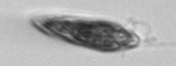

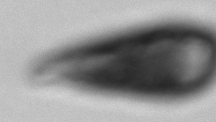

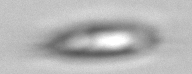

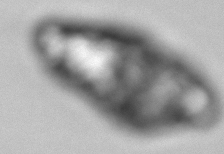

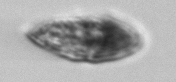

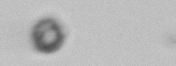

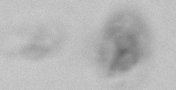

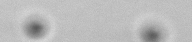

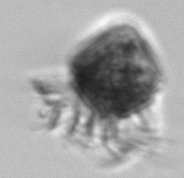

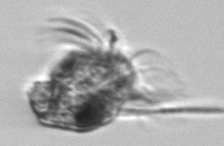

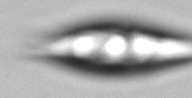

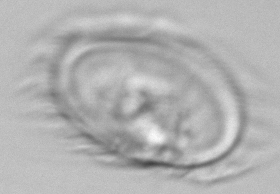

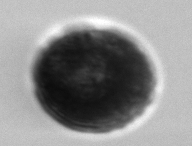

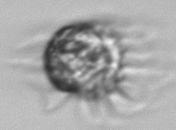

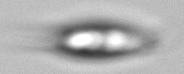

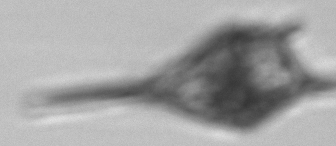

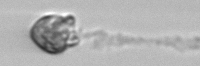

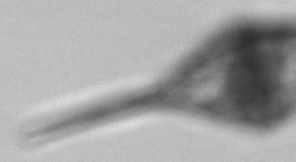

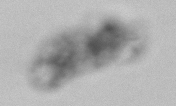

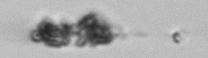

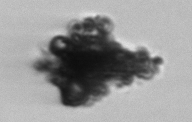

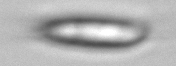

In [11]:
for idx in big_objects.index:
    example = img_ds.sel(index = idx)
    example_img = packet2img(example.roi_packet, example.roi_width, example.roi_height)
    display(example_img)

### Side Note: Looping Over Multiple IFCB Samples
If you wanted to iterate through all of the IFCB samples and save them to a netCDf, you could use the following code block. You probably shouldn't merge these datasets until you parse out and vectorize important information from the datasets attributes and reassign them as dataset variables or are confident you don't need that information.

```
for name, files in filesets.items():
    hdr_filepath = files['hdr']
    adc_filepath = files['adc']
    roi_filepath = files['roi']
    adc = load_adc(name, adc_filepath, hdr_filepath)
    roi_packets = split_roi(roi_filepath, adc)
    img_ds = xr.combine_by_coords([adc, roi_packets])
    
    img_ds.to_netcdf(f'{name}.nc')  # If you want to save the data as a netCDF.
```